#  Домашнее задание по NLP # 3 [100 баллов] 
## Классификация и генерация фамилий 

В этом домашнем задании вам предстоит классифицировать и генерировать фамилии на 19 разных языках. Обучающие данные хранятся в папке data и разбиты по языкам: один язык – одна подпапка. Ниже представлен код для считывания данных в словарь вида: 
```d{язык} : [список имен]```.

In [175]:
import nltk
import pandas as pd

from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, Dropout

from sklearn.model_selection import train_test_split

In [176]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

all_categories = []
category_lines = {}
for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Russian'][100:120])

['data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Spanish.txt']
['Abels', 'Abelsky', 'Abeltsev', 'Abelyan', 'Aberson', 'Abertasov', 'Abesadze', 'Abezgauz', 'Abgaryan', 'Abibulaev', 'Abidoff', 'Abidov', 'Abih', 'Abikh', 'Abisaloff', 'Abisalov', 'Abitoff', 'Abitov', 'Abjaliloff', 'Abjalilov']


## Часть 1. Предварительная обработка данных [10 баллов]

1. Удалите неоднозначные фамилии (т.е. одинаковые фамилии на разных языка), если такие есть;
2. Оцените 
    * среднюю длину фамилии по всей коллекции
    * по каждому языку
3. Для последующей классификации (части 2 и 3) оздайте обучающее и тестовое множество так, чтобы в обучающем множестве классы были сбалансированы: то есть, в обучающее множество должно входить примерно одинаковое количество фамилий на разных ящыка. 

In [177]:
df = pd.DataFrame.from_dict(category_lines, orient='index').T

In [178]:
df.head()

,Polish,Czech,French,Greek,Portuguese,Chinese,Japanese,Irish,English,Vietnamese,Russian,German,Arabic,Scottish,Korean,Italian,Dutch,Spanish
0,Adamczak,Abl,Abel,Adamidis,Abreu,Ang,Abe,Adam,Abbas,Nguyen,Ababko,Abbing,Khoury,Smith,Ahn,Abandonato,Aalsburg,Abana
1,Adamczyk,Adsit,Abraham,Adamou,Albuquerque,Au-Yong,Abukara,Ahearn,Abbey,Tron,Abaev,Abel,Nahas,Brown,Baik,Abatangelo,Aalst,Abano
2,Andrysiak,Ajdrna,Adam,Agelakos,Almeida,Bai,Adachi,Aodh,Abbott,Le,Abagyan,Abeln,Daher,Wilson,Bang,Abatantuono,Aarle,Abarca
3,Auttenberg,Alt,Albert,Akrivopoulos,Alves,Ban,Aida,Aodha,Abdi,Pham,Abaidulin,Abt,Gerges,Campbell,Byon,Abate,Achteren,Abaroa
4,Bartosz,Antonowitsch,Allard,Alexandropoulos,Araújo,Bao,Aihara,Aonghuis,Abel,Huynh,Abaidullin,Achilles,Nazari,Stewart,Cha,Abategiovanni,Achthoven,Abascal


In [179]:
f_df = df.stack().to_frame().reset_index()
del f_df['level_0']
f_df.columns = ['lang', 'second_names']
f_df.second_names = f_df.second_names.str.lower()
f_df.second_names = f_df.second_names.str.strip()

In [180]:
f_df.lang.value_counts()

Russian       9408
English       3668
Arabic        2000
Japanese       991
German         724
Italian        709
Czech          519
Spanish        298
Dutch          297
French         277
Chinese        268
Irish          232
Greek          203
Polish         139
Scottish       100
Korean          94
Portuguese      74
Vietnamese      73
Name: lang, dtype: int64

In [181]:
# удаление одинаковых фамилий
f_df.drop_duplicates(inplace=True, subset=['second_names'])

In [182]:
f_df[f_df.second_names.str.contains('[^\w\'-]+', regex=True)]

,lang,second_names
364,Portuguese,de santigo
1208,French,de la fontaine
1298,French,de sauveterre
1442,Spanish,de la cruz
1458,Spanish,de la fuente
1474,Spanish,del bosque
1490,Spanish,de leon
1522,Spanish,del olmo
3480,Chinese,lu:
3587,Spanish,san nicolas


In [183]:
chars = [char  for name in f_df.second_names.tolist() for char in name]
freq = nltk.FreqDist(chars)

print(list(freq.keys()))

['a', 'd', 'm', 'c', 'z', 'k', 'b', 'l', 'e', 'i', 's', 'r', 'u', 'n', 'g', 'y', 'o', 'h', 't', 'q', '-', 'v', 'w', 'j', 'p', 'x', 'ú', 'f', 'à', 'ó', 'ż', 'ü', 'é', "'", 'á', ' ', 'ä', 'ã', 'ń', 'í', 'ł', 'ò', 'õ', 'ö', 'ś', 'ą', 'ñ', 'ê', 'ç', 'ß', ':', '/', 'ù', '1', 'ì', 'è', ',', '\xa0']


In [184]:
f_df.drop(f_df[f_df.second_names.str.contains('[//1:\xa0,]', regex=True)].index,inplace=True)

In [185]:
chars = [char  for name in f_df.second_names.tolist() for char in name]
freq = nltk.FreqDist(chars)

print(list(freq.keys()))

['a', 'd', 'm', 'c', 'z', 'k', 'b', 'l', 'e', 'i', 's', 'r', 'u', 'n', 'g', 'y', 'o', 'h', 't', 'q', '-', 'v', 'w', 'j', 'p', 'x', 'ú', 'f', 'à', 'ó', 'ż', 'ü', 'é', "'", 'á', ' ', 'ä', 'ã', 'ń', 'í', 'ł', 'ò', 'õ', 'ö', 'ś', 'ą', 'ñ', 'ê', 'ç', 'ß', 'ù', 'ì', 'è']


In [186]:
chars = [char  for name in f_df.second_names.tolist() for char in name]
freq = nltk.FreqDist(chars)

print(list(freq.keys()))

['a', 'd', 'm', 'c', 'z', 'k', 'b', 'l', 'e', 'i', 's', 'r', 'u', 'n', 'g', 'y', 'o', 'h', 't', 'q', '-', 'v', 'w', 'j', 'p', 'x', 'ú', 'f', 'à', 'ó', 'ż', 'ü', 'é', "'", 'á', ' ', 'ä', 'ã', 'ń', 'í', 'ł', 'ò', 'õ', 'ö', 'ś', 'ą', 'ñ', 'ê', 'ç', 'ß', 'ù', 'ì', 'è']


In [187]:
f_df['len'] = f_df.second_names.str.len()

In [188]:
# средняя длинна
f_df.len.mean()

7.366622713982687

In [189]:
# средняя длинна по языку
f_df[['lang','len']].groupby(by=['lang']).mean().T

lang,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
len,5.592593,3.689498,6.598361,6.939929,6.431065,6.910506,6.753894,8.823834,7.05,7.036199,6.714431,3.450549,7.253623,6.418919,8.096382,6.5,6.576471,3.71875


In [190]:
X_train, X_test, y_train, y_test = train_test_split(f_df.second_names, f_df.lang,
                                                    test_size=0.3,
                                                    stratify=f_df.lang,
                                                    random_state=42)

##  Часть 2. Базовый метод классификации [20 баллов]



Используйте метод наивного Байеса, логистическую регрессию или любой другой метод для классификации фамилий: в качестве признаков используйте символьные $n$-граммы. Сравните результаты, получаемые при разных $n=2,3,4$ по $F$-мере и аккуратности. В каких случаях метод ошибается?

Для генерации $n$-грамм используйте:

In [191]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [197]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [192]:
vec = CountVectorizer(analyzer='char', ngram_range=(2,2))
X_train_n_2 = vec.fit_transform(X_train)
X_test_n_2 = vec.transform(X_test)

vec = CountVectorizer(analyzer='char', ngram_range=(3,3))
X_train_n_3 = vec.fit_transform(X_train)
X_test_n_3 = vec.transform(X_test)

vec = CountVectorizer(analyzer='char', ngram_range=(4,4))
X_train_n_4 = vec.fit_transform(X_train)
X_test_n_4 = vec.transform(X_test)

In [200]:
def print_score(model, X_tr, X_te, y_tr, y_te, n):
    model.fit(X_tr, y_tr)
    predict_train = model.predict(X_tr)
    predict_test = model.predict(X_te)
    print('{}, ngram = {}'.format(model.__class__.__name__, n))
    print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_tr, predict_train)))
    print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_te, predict_test)))
    print('F1 train: {0:6.4f}'.format(f1_score(y_tr, predict_train, average='weighted')))
    print('F1 test: {0:6.4f}'.format(f1_score(y_te, predict_test, average='weighted')))
    print(classification_report(y_te, predict_test))
    return predict_test

In [202]:
n_2_pred = print_score(MultinomialNB(), X_train_n_2, X_test_n_2, y_train, y_test,2)

MultinomialNB, ngram = 2
Accuracy train: 0.7775
Accuracy test: 0.7502
F1 train: 0.7541
F1 test: 0.7187
             precision    recall  f1-score   support

     Arabic       0.00      0.00      0.00        32
    Chinese       0.80      0.18      0.30        66
      Czech       0.50      0.13      0.21       147
      Dutch       0.66      0.22      0.33        85
    English       0.63      0.79      0.70      1014
     French       0.47      0.12      0.19        77
     German       0.54      0.43      0.48       193
      Greek       0.67      0.31      0.42        58
      Irish       0.71      0.38      0.50        66
    Italian       0.53      0.47      0.50       199
   Japanese       0.72      0.75      0.73       295
     Korean       0.00      0.00      0.00        27
     Polish       0.67      0.34      0.45        41
 Portuguese       0.50      0.05      0.08        22
    Russian       0.83      0.93      0.88      2786
   Scottish       0.00      0.00      0.00      

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [203]:
n_3_pred = print_score(MultinomialNB(), X_train_n_3, X_test_n_3, y_train, y_test,3)

MultinomialNB, ngram = 3
Accuracy train: 0.8296
Accuracy test: 0.7525
F1 train: 0.8101
F1 test: 0.7136
             precision    recall  f1-score   support

     Arabic       1.00      0.03      0.06        32
    Chinese       0.89      0.12      0.21        66
      Czech       0.57      0.11      0.18       147
      Dutch       0.80      0.28      0.42        85
    English       0.63      0.82      0.71      1014
     French       0.69      0.12      0.20        77
     German       0.51      0.38      0.44       193
      Greek       0.78      0.24      0.37        58
      Irish       0.85      0.17      0.28        66
    Italian       0.56      0.40      0.46       199
   Japanese       0.77      0.74      0.76       295
     Korean       0.00      0.00      0.00        27
     Polish       0.72      0.32      0.44        41
 Portuguese       1.00      0.05      0.09        22
    Russian       0.82      0.95      0.88      2786
   Scottish       0.00      0.00      0.00      

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [204]:
n_4_pred = print_score(MultinomialNB(), X_train_n_4, X_test_n_4, y_train, y_test,4)

MultinomialNB, ngram = 4
Accuracy train: 0.8649
Accuracy test: 0.7265
F1 train: 0.8440
F1 test: 0.6725
             precision    recall  f1-score   support

     Arabic       0.00      0.00      0.00        32
    Chinese       0.00      0.00      0.00        66
      Czech       0.89      0.05      0.10       147
      Dutch       0.92      0.26      0.40        85
    English       0.65      0.74      0.69      1014
     French       1.00      0.08      0.14        77
     German       0.68      0.27      0.39       193
      Greek       1.00      0.21      0.34        58
      Irish       0.67      0.09      0.16        66
    Italian       0.72      0.29      0.42       199
   Japanese       0.88      0.63      0.74       295
     Korean       0.00      0.00      0.00        27
     Polish       1.00      0.17      0.29        41
 Portuguese       0.50      0.05      0.08        22
    Russian       0.74      0.97      0.84      2786
   Scottish       0.00      0.00      0.00      

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


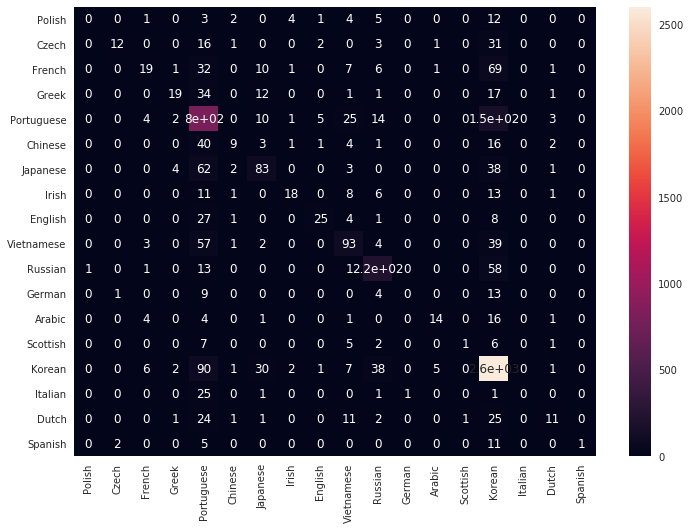

In [208]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data=confusion_matrix(y_test, n_2_pred),
            annot=True,
            xticklabels=df.columns,
            yticklabels=df.columns)

##  Часть 3. Нейронная сеть [35 баллов]


Используйте  реккурентную нейронную сеть с  LSTM для решения задачи. В ней может быть несколько слоев с LSTM, несколько слоев c Bidirectional(LSTM).  У нейронной сети один выход, определяющий класс фамилии. 

Представление имени для классификации в этом случае: 
1 вариант: бинарная матрица размера (количество букв в корпусе $\times$ максимальная длина имени). Обозначим его через $x$. Если первая буква имени a, то $x[1][1] = 1$, если вторая – b, то  $x[2][1] = 1$. То есть, используем one hot encoding для векторизации букв.  
2 вариант: Embedding'и символов. 

Выберите тот вариант, который вам проще или интереснее реализовать :) 

Не забудьте про регуляризацию нейронной сети дропаутами. 

Сравните результаты классификации разными методами по accuracy, micro- и macro- F-measure, precision, recall. Какой метод лучше и почему?

Сравните результаты, получаемые при разных значениях дропаута, разных числах узлов на слоях нейронной сети по $F$-мере и аккуратности. В каких случаях нейронная сеть ошибается?

Если совсем не получается запрограммировать нейронную сеть самостоятельно, обратитесь к туториалу тут: https://github.com/divamgupta/lstm-gender-predictor

##  Часть 4. Генерация фамилии [35 баллов]

Используйте архитектуру нейронной сети из Части 3 для генерации имени. В этот момент можно забыть про разбиение коллекции на обучающее и тестовое множество. 

Рассмотрите два сценария генерация имени:
* обучение нейронной сети по всей коллекции
* обучение нейронной сети с обуславливанием на язык

Для обуславливания на язык нужно изменить векторное представление фамилии. До этого момента мы разбивали фамилию на отдельные символы и находили векторное представление каждого символа. Теперь добавим в начало фамилии метку языка и будем ее считать первым символов фамилии. Так нейронная сеть научиться понимать, на каком языке написана фамилия. 

Пример: ```[rus bos i v a n o v eos pad pad pad]```

Когда будем генерировать новую фамилию, будем начинать процесс генерации не с символа начала последовательности ```bos```, а с символа языка и символа начала последовательности ```rus bos```. 

Привидите несколько примеров удачно сгенерированных фамилий. 